In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter, OrderedDict
import pickle

In [3]:
import glob
import json
from tqdm.notebook import tqdm

In [4]:
json_files = [
    json_file_id.split('/')[-1][:-5]
    for json_file_id in glob.glob('../data/json_files/*.json')
]

doc2json = {}

for doc in tqdm(json_files):
    # open the file in read mode
    file_path = "../data/json_files/" + doc + ".json"
    with open(file_path, "r", encoding='utf-8',) as file:
        # Load the JSON data
        doc2json[doc] = json.load(file)

  0%|          | 0/17486 [00:00<?, ?it/s]

In [5]:
len(doc2json)

17486

In [6]:

# read the metadat file into a pandas dataframe
metadata_file = '../data/Royal_Society_Corpus_open_v6.0_meta.tsv'

metadata_df = pd.read_csv(metadata_file, delimiter='\t')

metadata_df.head()

,id,issn,title,fpage,lpage,year,volume,journal,author,type,...,tokens,visualizationLink,doi,jstorLink,hasAbstract,isAbstractOf,primaryTopic,primaryTopicPercentage,secondaryTopic,secondaryTopicPercentage
0,rspa_1905_0001,0950-1207,"Address delivered by the President, Sir Willia...",1,29,1905,76,Proceedings of the Royal Society of London. Se...,"Sir William Huggins K. C. B., O. M., F. R. S.",speech,...,14279,http://corpora.clarin-d.uni-saarland.de/surpri...,10.1098/rspa.1905.0001,NaN,NaN,NaN,Biography,87.018807,Immunology,3.397728
1,rspa_1905_0002,0950-1207,"The boring of the Simplon Tunnel, and the dist...",29,33,1905,76,Proceedings of the Royal Society of London. Se...,"Francis Fox, M. Inst. C. E. |C. V. Boys, F. R. S.",article,...,1816,http://corpora.clarin-d.uni-saarland.de/surpri...,10.1098/rspa.1905.0002,NaN,NaN,NaN,Geography,34.843817,Thermodynamics,26.224835
2,rspa_1905_0003,0950-1207,On a method of finding the conductivity for heat.,34,48,1905,76,Proceedings of the Royal Society of London. Se...,"Professor C. Niven, F. R. S.",article,...,3624,http://corpora.clarin-d.uni-saarland.de/surpri...,10.1098/rspa.1905.0003,NaN,NaN,NaN,Electricity,22.229782,Formulae,19.054271
3,rspa_1905_0004,0950-1207,Theory of the reflection of light near the pol...,49,65,1905,76,Proceedings of the Royal Society of London. Se...,"Richard C. Maclaurin, M. A., LL. D.|Professor ...",article,...,2722,http://corpora.clarin-d.uni-saarland.de/surpri...,10.1098/rspa.1905.0004,NaN,NaN,NaN,Tables,38.543461,Fluid Dynamics,28.361855
4,rspa_1905_0005,0950-1207,On the relation between variations of atmosphe...,66,86,1905,76,Proceedings of the Royal Society of London. Se...,"Captain H. G. Lyons|Sir W. E. Garstin, G. C. M...",article,...,10079,http://corpora.clarin-d.uni-saarland.de/surpri...,10.1098/rspa.1905.0005,NaN,NaN,NaN,Meteorology,51.203697,Geography,22.031809


In [7]:
# add year, decade, and period to the dictionaries in doc2json

for doc in tqdm(doc2json):
    df_row = metadata_df.loc[metadata_df['id'] == doc]
    year = df_row['year']
    decade = df_row['decade']
    period = df_row['period']

    doc2json[doc]['year'] = year
    doc2json[doc]['decade'] = decade
    doc2json[doc]['period'] = period

  0%|          | 0/17486 [00:00<?, ?it/s]

In [8]:
VALID_CATEGORIES = {
    'Astronomy',
    'Biology & Life Sciences',
    'Chemistry',
    'Engineering & Technology',
    'Environmental & Earth Sciences',
    'Mathematics & Statistics',
    'Medicine & Health Sciences',
    'Physics',
    'Social Sciences & Humanities'
}


In [9]:
decade2categories= defaultdict(list)

for doc in tqdm(doc2json):
    decade = doc2json[doc]['decade'].values[0]
    category = doc2json[doc]['scientific_discipline']
    
    if category in VALID_CATEGORIES:
        decade2categories[decade].append(category) 
    elif category == 'Earth Sciences':
        decade2categories[decade].append('Environmental & Earth Sciences')

  0%|          | 0/17486 [00:00<?, ?it/s]

In [10]:
DECADES = sorted(list(decade2categories.keys()))

# dict to get a distribution of categories for each decade
decade2category_distribution = {} 

for decade in DECADES:
    category_counter = defaultdict(int)

    for category in VALID_CATEGORIES:
        category_counter[category] = decade2categories[decade].count(category)

    total_categories = sum(category_counter.values())

    category_distribution = {
        category: 100*(count / total_categories)
        for category, count in category_counter.items()
    }

    decade2category_distribution[decade] = category_distribution

In [11]:
decade2category_distribution[1660]

{'Social Sciences & Humanities': 3.3112582781456954,
 'Mathematics & Statistics': 4.966887417218543,
 'Engineering & Technology': 2.6490066225165565,
 'Biology & Life Sciences': 16.887417218543046,
 'Medicine & Health Sciences': 13.57615894039735,
 'Physics': 7.6158940397351,
 'Chemistry': 6.291390728476822,
 'Environmental & Earth Sciences': 33.443708609271525,
 'Astronomy': 11.258278145695364}

In [12]:
decade2distribution_moving_average = {}

for decade in DECADES[1:-1]:
    category_distribution = decade2category_distribution[decade]

    category_distribution_next = decade2category_distribution[decade + 10]
    category_distribution_previous = decade2category_distribution[decade - 10]

    category_distribution_moving_average = {
        category: (
            category_distribution[category] ++
            category_distribution_next[category] ++
            category_distribution_previous[category]
        ) / 3

        for category in VALID_CATEGORIES
    }

    decade2distribution_moving_average[decade] = category_distribution_moving_average

In [13]:
decade2distribution_moving_average_2 = {}

for decade in DECADES[2:-2]:
    category_distribution = decade2category_distribution[decade]

    category_distribution_next = decade2category_distribution[decade + 10]
    category_distribution_next_next = decade2category_distribution[decade + 20]
    category_distribution_previous = decade2category_distribution[decade - 10]
    category_distribution_previous_previous = decade2category_distribution[decade - 10]

    category_distribution_moving_average = {
        category: (
            category_distribution[category] ++
            category_distribution_next[category] ++
            category_distribution_previous[category] ++
            category_distribution_next_next[category] ++
            category_distribution_previous_previous[category]
        ) / 5

        for category in VALID_CATEGORIES
    }

    decade2distribution_moving_average_2[decade] = category_distribution_moving_average

In [14]:
# Set up LaTeX fonts
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica'] # 

In [15]:
category2color = {
    'Biology & Life Sciences': '#2E7D32',  # Earthy dark green, connecting with the environment
    'Medicine & Health Sciences': 'maroon',  # Deep pink, conveying care and attention
    'Environmental & Earth Sciences': 'goldenrod',  # Brown, representing the earth and environment
    'Physics': '#1976D2',  # Medium blue, indicating clarity and precision
    'Astronomy': 'navy', #'#0D47A1',  # Deep blue, representing the vastness of space
    'Engineering & Technology': 'yellowgreen', #'gold', #'#F57C00',  # Bright orange, representing innovation and creativity
    'Mathematics & Statistics': '#6A1B9A',  # Amethyst purple, symbolizing complexity and depth
    'Social Sciences & Humanities': 'pink',  # Dark brown, suggesting tradition and study
    'Chemistry': '#D32F2F',  # Vibrant red, reflecting the energy of chemical reactions
}

In [16]:
category2color = {
    'Biology & Life Sciences': '#2E7D32',  # Earthy dark green, connecting with the environment
    'Medicine & Health Sciences': 'maroon',  # Deep pink, conveying care and attention
    'Environmental & Earth Sciences': 'darkgoldenrod', #'darkbrown', # Brown, representing the earth and environment
    'Physics': 'dodgerblue', #'#1976D2',  # Medium blue, indicating clarity and precision
    'Astronomy': 'navy', #'#0D47A1',  # Deep blue, representing the vastness of space
    'Engineering & Technology': 'yellowgreen', #'gold', #'#F57C00',  # Bright orange, representing innovation and creativity
    'Social Sciences & Humanities': 'pink',  # Dark brown, suggesting tradition and study
    'Mathematics & Statistics': '#6A1B9A',  # Amethyst purple, symbolizing complexity and depth
    'Chemistry': 'gold', #'crimson', #darkslategray', #'#D32F2F',  # Vibrant red, reflecting the energy of chemical reactions
    #'Other': 'gray', 
}

In [35]:
def plot_distribution(decade2distribution, decades, title, filename):
    # plot a stacked bar chart of the distribution
    # of scientific disciplines over time
    fig, ax = plt.subplots(figsize=(12, 5))

    for decade in tqdm(decades):
        category_distribution = decade2distribution[decade]

        bottom = 0
        for category in category2color:
            percentage = category_distribution[category]
            ax.bar(
                decade, 
                percentage, 
                bottom=bottom, 
                color=category2color[category], 
                label=category, 
                width=10
            )
            bottom += percentage

        
    ax.set_xlabel('Decade')
    ax.set_ylabel('Percentage of Articles')
    ax.set_title('Distribution of Scientific Disciplines Over Time')
    ax.set_ylim(0, 100)

    plt.xticks(decades, rotation=30, fontsize=12)
    plt.tight_layout()

    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('plots/' + filename)
    plt.show()


  0%|          | 0/27 [00:00<?, ?it/s]

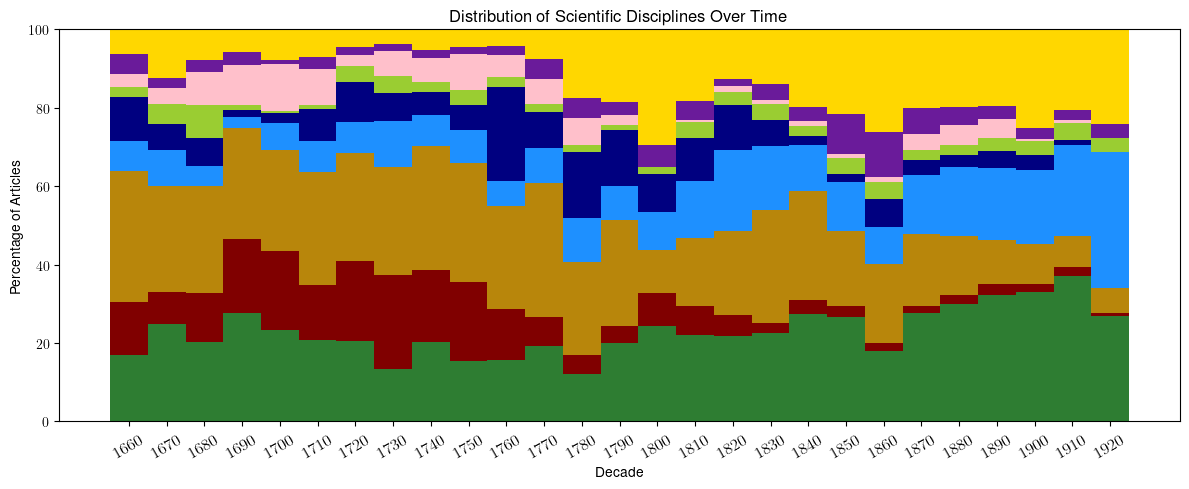

In [36]:
plot_distribution(decade2category_distribution,
    DECADES, 
    title='Distribution of Scientific Disciplines Over Time',
    filename='distribution_over_time_1.png', 
)

  0%|          | 0/25 [00:00<?, ?it/s]

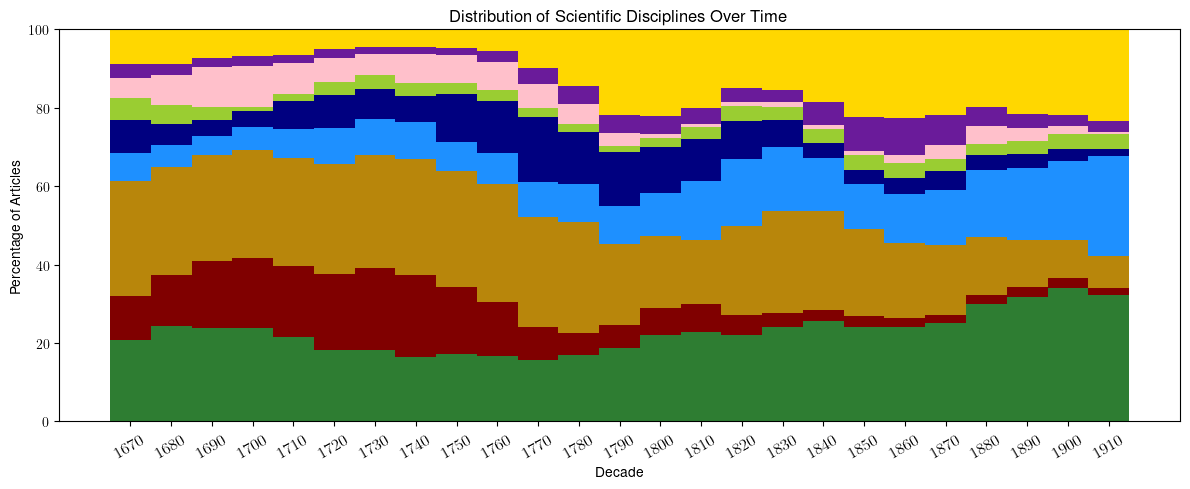

In [37]:
plot_distribution(decade2distribution_moving_average,
    DECADES[1:-1], 
    title='Distribution of Scientific Disciplines Over Time',
    filename='distribution_over_time_2.pdf', 
)

  0%|          | 0/23 [00:00<?, ?it/s]

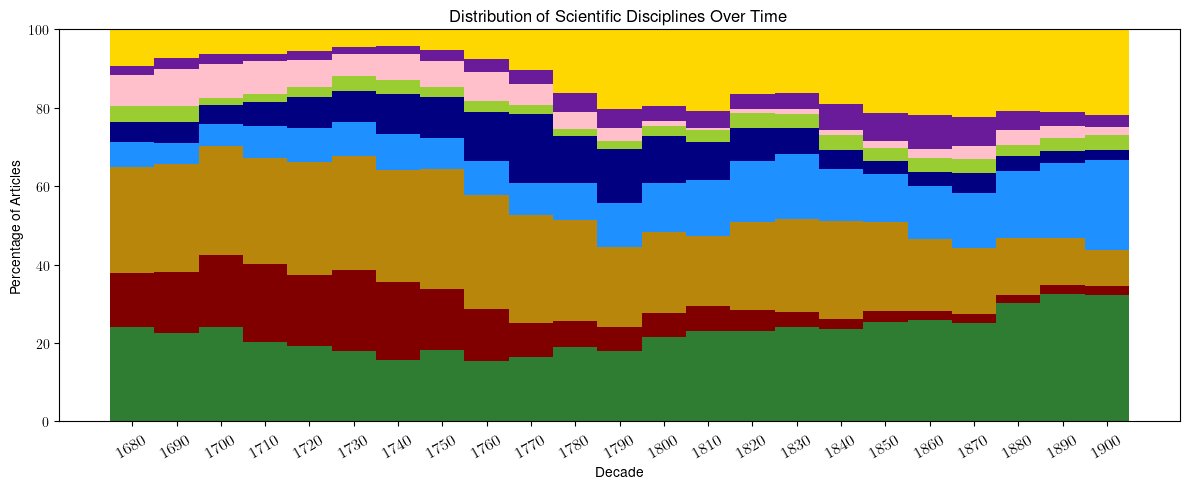

In [38]:
plot_distribution(
    decade2distribution_moving_average_2,
    DECADES[2:-2], 
    title='Distribution of Scientific Disciplines Over Time',
    filename='distribution_over_time_2.png', 
)

In [21]:
LLM_categories = [
    doc2json[i]['scientific_discipline'] 
    for i in doc2json
]

total_num = len(LLM_categories)

num_valid_categories = 0

for category, count in Counter(LLM_categories).most_common():
    perc = count/total_num
    print(f"{category}: {perc*100:.3f}%")

    if category in VALID_CATEGORIES:
        num_valid_categories += count

perc_valid_categories = 100*(num_valid_categories/total_num)
print(f"Perecentage of valid categories: {perc_valid_categories:.2f}%" )

Biology & Life Sciences: 25.506%
Chemistry: 17.088%
Environmental & Earth Sciences: 14.526%
Physics: 13.943%
Medicine & Health Sciences: 6.113%
Astronomy: 5.736%
Mathematics & Statistics: 4.506%
Earth Sciences: 4.444%
Social Sciences & Humanities: 3.363%
Engineering & Technology: 3.306%
Mathematics: 0.629%
Earth & Environmental Sciences: 0.263%
Materials Science: 0.103%
Psychology: 0.057%
Music & Acoustics: 0.046%
Multi-disciplinary: 0.034%
Medicine: 0.034%
General Science: 0.029%
Art & Humanities: 0.023%
Earth Sciences & Astronomy: 0.023%
Biology: 0.023%
Music: 0.017%
Various: 0.017%
Philosophy: 0.011%
Astronomy & Astrophysics: 0.011%
History: 0.011%
Optics & Light: 0.011%
Earth Sciences & Geology: 0.006%
Earth Sciences & Medicine: 0.006%
Earth Sciences & Life Sciences: 0.006%
History & Archaeology: 0.006%
Earth Sciences & Environmental Sciences: 0.006%
Optics: 0.006%
Agriculture & Food Sciences: 0.006%
History & Philosophy of Science: 0.006%
Earth Sciences & Mathematics: 0.006%
Music

In [22]:
LLM_subcategories = [
    doc2json[i]['scientific_subdiscipline'] for i in doc2json
]

total_num = len(doc2json)

llm_subcategories = []

for field, count in Counter(LLM_subcategories).most_common():
    perc = count/total_num
    print(f"{field}: {count} {perc*100:.3f}%")

    subfields = field.split('&')

    llm_subcategories.extend([f.strip() for f in subfields])

Optics & Light: 453 2.591%
Meteorology & Climatology: 451 2.579%
Anatomy & Physiology: 272 1.556%
Botany & Plant Science: 266 1.521%
Geophysics & Geomagnetism: 234 1.338%
Plant Biology & Ecology: 176 1.007%
Physical Chemistry & Thermodynamics: 166 0.949%
Thermodynamics & Heat Transfer: 152 0.869%
Physical Chemistry & Chemical Physics: 150 0.858%
Neuroscience & Neurobiology: 149 0.852%
Electromagnetism & Magnetic Materials: 148 0.846%
Organic Chemistry & Biochemistry: 142 0.812%
Geometry & Topology: 135 0.772%
Meteorology & Atmospheric Science: 130 0.743%
Zoology & Animal Anatomy: 129 0.738%
Developmental Biology & Embryology: 122 0.698%
Materials Science & Metallurgy: 122 0.698%
Electromagnetism & Electrodynamics: 121 0.692%
Zoology & Animal Physiology: 118 0.675%
Physical Chemistry & Electrochemistry: 117 0.669%
Geology & Mineralogy: 113 0.646%
Zoology & Invertebrate Biology: 113 0.646%
Inorganic Chemistry & Materials: 109 0.623%
Analysis & Calculus: 108 0.618%
Geodesy & Geophysics: 1

In [43]:
len(set(LLM_subcategories)) #, len(set(LLM_topics)) # 25138 2714

2714

In [23]:
total_num

17486

In [25]:
# L = ['Optics', 'Music']
# L.extend(f.strip() for f in fields)
# L

In [26]:
LLM_subcategories

['Geophysics & Magnetism',
 'Inorganic Chemistry & Materials',
 'Organic Chemistry & Biochemistry',
 'Instruments & Devices',
 'Botany & Plant Science',
 'Inorganic & Analytical Chemistry',
 'Algebra & Calculus',
 'Zoology & Animal Behavior',
 'Oceanography & Hydrodynamics',
 'Electromagnetism & Magnetic Fields',
 'Materials Science & Engineering',
 'Human Physiology & Respiration',
 'Statistical Analysis & Methods',
 'Plant Biology & Physiology',
 'Anatomy & Physiology',
 'Geology & Mineralogy',
 'Historical Chemistry & Alchemy',
 'Biochemistry & Chemical Biology',
 'Toxicology & Pharmacology',
 'Physical Chemistry & Thermodynamics',
 'Observational Astronomy & Instrumentation',
 'Physical Chemistry & Thermodynamics',
 'Genetics & Evolution',
 'Ophthalmology & Optometry',
 'Celestial Object Classification & Study',
 'Mineralogy & Petrology',
 'Geophysics & Geomagnetism',
 'Electromagnetism & Electromechanical Systems',
 'Organic Chemistry & Compounds',
 'Thermodynamics & Heat Transfer

In [27]:
Counter(LLM_subcategories)

Counter({'Geophysics & Magnetism': 90,
         'Inorganic Chemistry & Materials': 109,
         'Organic Chemistry & Biochemistry': 142,
         'Instruments & Devices': 2,
         'Botany & Plant Science': 266,
         'Inorganic & Analytical Chemistry': 1,
         'Algebra & Calculus': 7,
         'Zoology & Animal Behavior': 86,
         'Oceanography & Hydrodynamics': 5,
         'Electromagnetism & Magnetic Fields': 21,
         'Materials Science & Engineering': 83,
         'Human Physiology & Respiration': 2,
         'Statistical Analysis & Methods': 5,
         'Plant Biology & Physiology': 45,
         'Anatomy & Physiology': 272,
         'Geology & Mineralogy': 113,
         'Historical Chemistry & Alchemy': 1,
         'Biochemistry & Chemical Biology': 23,
         'Toxicology & Pharmacology': 26,
         'Physical Chemistry & Thermodynamics': 166,
         'Observational Astronomy & Instrumentation': 23,
         'Genetics & Evolution': 19,
         'Ophthalmology

In [29]:
trgt = "Multi-disciplinary" # Psycholinguistics & Language Development #  & Acoustics

for doc in doc2json:
    if doc2json[doc]['scientific_discipline'] == trgt:
        for k, v in doc2json[doc].items():
            print(f"{k}: {v}")
        print()

article_id: rspl_1895_0130
revised_title: List of Scientific Publications, May 9, 1895
topics: ['Biology & Life Sciences', 'Chemistry', 'Earth Sciences', 'Mathematics & Statistics', 'Physics']
tldr: This article presents a comprehensive list of scientific publications from various journals and societies, covering topics in biology, chemistry, earth sciences, mathematics, and physics, as of May 9, 1895.
scientific_discipline: Multi-disciplinary
scientific_subdiscipline: Scientific Literature Review
year: 5279    1895
Name: year, dtype: int64
decade: 5279    1890
Name: decade, dtype: int64
period: 5279    1850
Name: period, dtype: int64

article_id: rspl_1887_0207
revised_title: Scientific Presentations and Publications from June 16, 1887
topics: ['Scientific journals', 'Scientific literature', 'Research publications', 'Scientific societies', 'Scientific communication']
tldr: This article presents a list of scientific papers, publications, and transactions from various scientific journal

In [30]:
trgt = "Music" # Psycholinguistics & Language Development #  & Acoustics
12
for doc in doc2json:
    if doc2json[doc]['scientific_discipline'] == trgt:
        for k, v in doc2json[doc].items():
            print(f"{k}: {v}")
        print()

article_id: 105414
revised_title: An Explanation of Ancient Greek Musical Modes
topics: ['Ancient Greek Music', 'Musical Theory', 'Harmonic Modes', 'Musical Doctrine', 'Ptolemaic Modes']
tldr: The author examines and explains the harmonic and musical doctrines of ancient Greek music, focusing on the seven modes accepted by Ptolemy. He demonstrates that both doctrines can be reconciled under a single interpretation and provides a comprehensive explanation of the modes, their origins, and their differences.
scientific_discipline: Music
scientific_subdiscipline: Music Theory & History
year: 11220    1759
Name: year, dtype: int64
decade: 11220    1750
Name: decade, dtype: int64
period: 11220    1750
Name: period, dtype: int64

article_id: 105877
revised_title: A Child Prodigy: The Extraordinary Musical Talents of Mozart
topics: ['Musical prodigies', 'Child musicians', "Mozart's early life", 'Music composition', 'Harpsichord']
tldr: The article narrates the early life and extraordinary musi

In [31]:
trgt = "Psycholinguistics & Language Development"

for doc in doc2json:
    if doc2json[doc]['scientific_subdiscipline'] == trgt:
        for k, v in doc2json[doc].items():
            print(f"{k}: {v}")
        print()

article_id: 101583
revised_title: Teaching a Dumb and Deaf Person to Speak and Understand Language
topics: ['Communication', 'Language Acquisition', 'Deaf Education', 'Speech Therapy', 'Language Development']
tldr: The author, Dr. John Wallis, shares his experience and success in teaching a dumb and deaf person to speak and understand language. He discusses the challenges and methods used in teaching speech and language, as well as the importance of discourse and understanding in language acquisition.
scientific_discipline: Biology & Life Sciences
scientific_subdiscipline: Psycholinguistics & Language Development
year: 8249    1670
Name: year, dtype: int64
decade: 8249    1670
Name: decade, dtype: int64
period: 8249    1650
Name: period, dtype: int64



In [34]:
for doc in doc2json:
    if 'Therm' in doc2json[doc]['topics']:
        for k, v in doc2json[doc].items():
            print(f"{k}: {v}")
            
        print('---')

article_id: 108691
revised_title: Investigation of Thermo-Dynamic Properties of Solids and the Development of a Sensitive Thermo-Multiplier
topics: ['Thermal Properties of Solids', 'Therm', 'Therm', 'Thermal Expansion', 'Thermal Conductivity']
tldr: Joule investigates the thermo-dynamic properties of solids, specifically the heat evolved by the compression of elastic fluids, and develops a sensitive thermo-multiplier to measure temperature changes. He finds that the heat evolved is approximately equivalent to the work spent, and that a gas can be conceived as having properties that do not evolve heat upon compression.
scientific_discipline: Physics
scientific_subdiscipline: Thermodynamics & Heat Transfer
year: 13989    1859
Name: year, dtype: int64
decade: 13989    1850
Name: decade, dtype: int64
period: 13989    1850
Name: period, dtype: int64
---
article_id: 112311
revised_title: Thermo-Electric Currents of Ritterian Species: A Study on Electromotive Force and Metal Tensions
topics: 

In [92]:
doc2json['101427']

{'article_id': '101427',
 'revised_title': 'A Defense of the Grinding Method for Long Object-Glasses',
 'topics': ['Optical Engineering',
  'Glass Grinding',
  'Telescopes',
  'Refraction',
  'Machining'],
 'tldr': 'The author defends his method for grinding long object-glasses and addresses objections raised by Monsieur Auzout. He argues that his method is more precise and efficient than traditional hand grinding and can produce high-quality lenses for telescopes.',
 'scientific_discipline': 'Physics',
 'scientific_subdiscipline': 'Optics & Light',
 'year': 8114    1665
 Name: year, dtype: int64,
 'decade': 8114    1660
 Name: decade, dtype: int64,
 'period': 8114    1650
 Name: period, dtype: int64}

In [139]:
len(set(LLM_topics))

25138

In [138]:
LLM_topics = [
     t.lower() for doc in doc2json
     for t in doc2json[doc]['topics'] 
]

Counter(LLM_topics).most_common()

[('astronomy', 1110),
 ('meteorology', 746),
 ('spectroscopy', 702),
 ('geology', 617),
 ('anatomy', 435),
 ('chemical reactions', 415),
 ('magnetism', 389),
 ('celestial mechanics', 388),
 ('optics', 387),
 ('zoology', 377),
 ('botany', 362),
 ('geophysics', 335),
 ('geometry', 286),
 ('paleontology', 284),
 ('mineralogy', 273),
 ('chemical analysis', 270),
 ('chemistry', 263),
 ('electrochemistry', 255),
 ('natural history', 251),
 ('geodesy', 250),
 ('mathematical analysis', 247),
 ('telescopes', 245),
 ('crystallography', 239),
 ('organic chemistry', 235),
 ('embryology', 229),
 ('marine biology', 228),
 ('electricity', 224),
 ('plant physiology', 213),
 ('microscopy', 211),
 ('atmospheric pressure', 207),
 ('geography', 205),
 ('natural disasters', 201),
 ('astrophysics', 194),
 ('metallurgy', 192),
 ('fluid dynamics', 192),
 ('oceanography', 191),
 ('neuroanatomy', 188),
 ('experimental physics', 183),
 ('neuroscience', 180),
 ('observational astronomy', 176),
 ('thermodynamics',

In [123]:
LLM_topics_set = set(LLM_topics)

'speech production' in LLM_topics_set, len(LLM_topics_set)

(True, 25138)

In [95]:
LLM_topics_set = set(LLM_topics)

"Halley's Comet".lower() in LLM_topics_set

True

In [125]:
Counter(LLM_topics).most_common(50)

[('astronomy', 1110),
 ('meteorology', 746),
 ('spectroscopy', 702),
 ('geology', 617),
 ('anatomy', 435),
 ('chemical reactions', 415),
 ('magnetism', 389),
 ('celestial mechanics', 388),
 ('optics', 387),
 ('zoology', 377),
 ('botany', 362),
 ('geophysics', 335),
 ('geometry', 286),
 ('paleontology', 284),
 ('mineralogy', 273),
 ('chemical analysis', 270),
 ('chemistry', 263),
 ('electrochemistry', 255),
 ('natural history', 251),
 ('geodesy', 250),
 ('mathematical analysis', 247),
 ('telescopes', 245),
 ('crystallography', 239),
 ('organic chemistry', 235),
 ('embryology', 229),
 ('marine biology', 228),
 ('electricity', 224),
 ('plant physiology', 213),
 ('microscopy', 211),
 ('atmospheric pressure', 207),
 ('geography', 205),
 ('natural disasters', 201),
 ('astrophysics', 194),
 ('metallurgy', 192),
 ('fluid dynamics', 192),
 ('oceanography', 191),
 ('neuroanatomy', 188),
 ('experimental physics', 183),
 ('neuroscience', 180),
 ('observational astronomy', 176),
 ('thermodynamics',

In [141]:
target_topics = [
    'Language Acquisition', 'Speech Therapy', 'Deaf Education', 'Deafness', 
    'Sign Language', 'Hearing Loss', 'Auditory Processing Disorder', 'Cochlear Implants'
    'Speech Perception', 'Speech Production', 'Speech Recognition', 'Speech Synthesis',
    'Language Development', 'Language Processing', 'Language Production', 'Language Recognition',
    'Language & Cognition', 'Language & Communication', 'Language & Culture', 'Language & Education', 
    'Language & Literacy', 'Language & Memory', 'Language & Music', 'Language & Perception',
    'Language & Linguisitcs', 'Language & Psychology', 'Language & Society', 'Language & Technology',
    'Communication Disorders', 'Communication Skills', 'Communication Strategies', 'Communication Systems',
    'Grammar', 'Syntax', 'Semantics', 'Pragmatics', 'Phonetics', 'Phonology', 'Orthography',
    'Phonemes', 'Phonics', 'Phonotactics', 'Prosody', 'Intonation', 'Rhythm', 'Tone',   'Language Phonetics',   'Pronunciation',
  'Linguistics', 'Linguistic Analysis', 'Linguistic Anthropology', 'Linguistic Diversity', 'Linguistic Theory',
    'Vowels', 'Consonants', 'Syllables', 'Words', 'Sentences', 'Paragraphs', 'Discourse', 'Narrative',
    'Psycholinguistics', 'Neurolinguistics', 'Sociolinguistics', 'Computational Linguistics', 'Cognitive Linguistics',
    'Alphabets', 'Writing Systems', 'Scripts', 'Punctuation', 'Typography', 'Calligraphy', 'Handwriting', 'Alphabet',
]

for doc in doc2json: 
    if  set(doc2json[doc]['topics']).intersection(target_topics):
        print(f"ID: {doc2json[doc]['article_id']}")
        print(f"year: {doc2json[doc]['year'].values[0]}")
        print(f"Title: {doc2json[doc]['revised_title']}")
        print(f"Topics: {doc2json[doc]['topics']}")
        print(f"Discipline: {doc2json[doc]['scientific_discipline']}")
        print(f"Subdiscipline: {doc2json[doc]['scientific_subdiscipline']}")
        print(f"TL;DR: {doc2json[doc]['tldr']}")
        print()

ID: rspl_1873_0043
year: 1873
Title: On the Pneumatic Action in Articulation of Sounds by the Human Voice: A Study Using a Recording Instrument
Topics: ['Speech Production', 'Articulation', 'Pneumatics', 'Recording Instruments', 'Voice Physiology']
Discipline: Biology & Life Sciences
Subdiscipline: Speech & Language Sciences
TL;DR: The author constructs a recording instrument to study the pneumatic action accompanying the articulation of sounds by the human voice. The instrument records the expulsion of air from the mouth during speech, revealing variations in pneumatic actions for different articulations and providing insights into the process and effects of articulation.

ID: 111351
year: 1856
Title: The Thyroid Body and Its Function in Vocal Production
Topics: ['Endocrinology', 'Larynx Anatomy', 'Voice Physiology', 'Thyroid Gland Function', 'Speech Production']
Discipline: Medicine & Health Sciences
Subdiscipline: Endocrinology & Physiology
TL;DR: The author, Peter Martyn, investiga

In [122]:
doc2json['101842']

{'article_id': '101842',
 'revised_title': 'Observations and Conjectures on the Chinese Characters and their Antiquity',
 'topics': ['Chinese Language',
  'Writing Systems',
  'Artificial Languages',
  'History of Printing',
  'Numeral Systems'],
 'tldr': 'The author examines the Chinese writing system, its antiquity, and its influence on the development of printing. They compare the Chinese abacus to the Roman abacus and discuss the differences in their numeral systems and writing methods.',
 'scientific_discipline': 'Social Sciences & Humanities',
 'scientific_subdiscipline': 'Linguistics & Semiotics',
 'year': 8431    1686
 Name: year, dtype: int64,
 'decade': 8431    1680
 Name: decade, dtype: int64,
 'period': 8431    1650
 Name: period, dtype: int64}

In [140]:
doc2json['101850']

{'article_id': '101850',
 'revised_title': 'Proposing an Universal Alphabet for Accurate Language Representation',
 'topics': ['Alphabet Development',
  'Language Phonetics',
  'Pronunciation',
  'Linguistics',
  'Communication'],
 'tldr': 'The author, Francis Lodwick, presents an essay on the development of an universal alphabet to accurately represent and pronounce all sounds in languages. The proposed alphabet aims to overcome the limitations of existing alphabets, enabling easier learning and understanding of various languages.',
 'scientific_discipline': 'Social Sciences & Humanities',
 'scientific_subdiscipline': 'Linguistics & Language Studies',
 'year': 8438    1686
 Name: year, dtype: int64,
 'decade': 8438    1680
 Name: decade, dtype: int64,
 'period': 8438    1650
 Name: period, dtype: int64}